In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [4]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [5]:
N = 100 # total ids 
pi = 3.14

LRU

In [6]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  return y

LFU

In [7]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [8]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

GREEDY

In [9]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = float)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = float)
  z = np.zeros((I,N),dtype = float)
  mark = np.zeros((I,N),dtype = float)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_cache] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

SINGLE CACHE

In [10]:
I = 1 #users
T = 100000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [11]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 100000)

In [12]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 100000)

In [13]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])

  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
 
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 4 1 1 1
10000 36815 9397 9477 9477
20000 63309 18715 18994 18994
30000 85340 28029 28465 27616
40000 102523 37355 37919 36214
50000 117468 46740 47407 44815
60000 130336 56073 56865 53412
70000 141659 65392 66324 62018
80000 152337 74733 75808 70578
90000 162296 84087 85340 79217


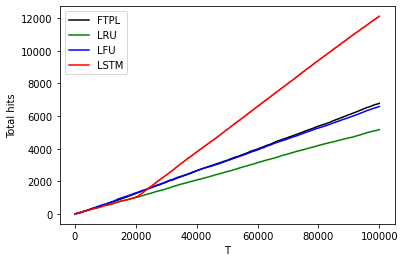

In [14]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

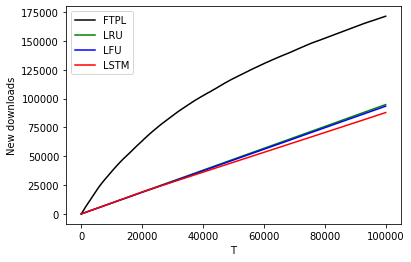

In [15]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 2

In [16]:
C = 5
I = 5
J = 3
degree = 3
T = 20000

In [17]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 1]])

In [18]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [19]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 20000)

In [20]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 20000)

In [21]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)

  [y_FTPL,z] = Greedy(connection,perturbed_count)
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 15 9 9 9 0.0 0.0 0.0 0.0
1000 13043 8351 8405 8123 381.0 397.0 352.0 529.0
2000 25433 16728 16823 16272 811.0 785.0 719.0 1072.0
3000 36983 25113 25277 24408 1231.0 1149.0 1036.0 1593.0
4000 47588 33411 33673 32549 1666.0 1570.0 1385.0 2135.0
5000 57269 41753 42092 40568 2068.0 1946.0 1718.0 2733.0
6000 66653 50147 50502 48666 2476.0 2312.0 2074.0 3299.0
7000 75803 58474 58871 56769 2871.0 2686.0 2452.0 3848.0
8000 84510 66897 67345 64902 3244.0 3009.0 2776.0 4377.0
9000 93140 75292 75771 72985 3641.0 3378.0 3120.0 4936.0
10000 101595 83738 84279 81058 4057.0 3706.0 3413.0 5515.0
11000 109719 92113 92715 89189 4480.0 4073.0 3751.0 6066.0
12000 117640 100492 101154 97318 4861.0 4423.0 4069.0 6612.0
13000 125480 108906 109594 105336 5262.0 4780.0 4407.0 7188.0
14000 133376 117233 118004 113462 5691.0 5171.0 4753.0 7741.0
15000 140857 125629 126482 121595 6106.0 5539.0 5075.0 8287.0
16000 148230 133976 134883 129700 6498.0 5906.0 5424.0 8856.0
17000 155610 142385 143375 137771 6900.0 62

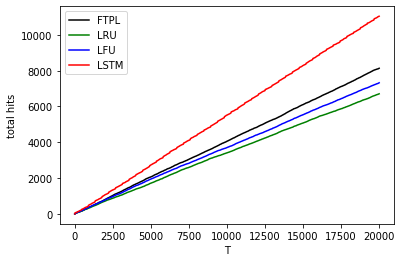

In [22]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=2).png')

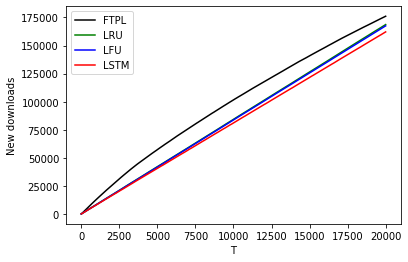

In [23]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=2).png')

I = 15 J = 10 d = 7

In [24]:
I = 15
J = 10
C = 10
degree = 7
T = 10000

In [25]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [26]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [27]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 10000)

In [28]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 10000)

In [29]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0

req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  [y_FTPL,z] = Greedy(connection,perturbed_count)

  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 99 63 63 54 1.0 1.0 1.0 0.0
1000 66605 60008 60686 58821 3445.0 2714.0 2477.0 2909.0
2000 124498 120110 121516 117443 6651.0 5313.0 4916.0 5914.0
3000 174583 180286 182625 175909 9650.0 7816.0 7334.0 8950.0
4000 217548 240439 243568 234358 12512.0 10369.0 9803.0 11982.0
5000 256226 300925 304747 292410 15287.0 12879.0 12190.0 15137.0
6000 291258 361101 365858 351035 18050.0 15427.0 14602.0 18129.0
7000 323656 421388 426659 409501 20719.0 17987.0 17103.0 21154.0
8000 355702 481568 487549 467928 23377.0 20550.0 19592.0 24205.0
9000 385991 541846 548597 526060 26069.0 23003.0 21989.0 27263.0


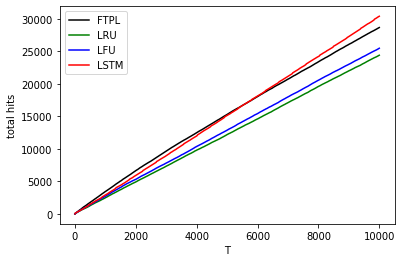

In [30]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

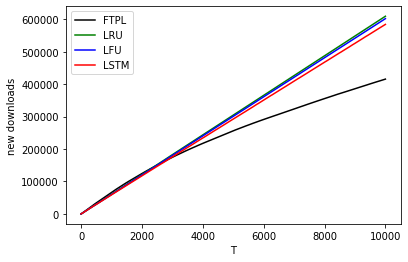

In [31]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')